we will make 3 filters:

1 for phising

1 for advertising (advertising products and services with pay)

1 for social_promotion (people advertising himself or others no pay)

We train in imbalanced data, so the results of spam class precision is a bit low
so we try to increase it, via weighting class training
using the Formula of Class Weights

This formula is known as the "inverse class frequency"

wj=n_samples / (n_classes * n_samplesj)

In [1]:
!pip install transformers

In [2]:
# import libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
RANDOM_STATE = 56
torch.cuda.manual_seed_all(56)
torch.manual_seed(56)

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# load the data

sms = pd.read_csv('/content/drive/MyDrive/spam_detection/sms_translate.csv') # load spam dataset
sms_ham = sms.loc[sms.Category==0,['Message','gtrans_el']] # sms ham messages
sms_spam = pd.read_csv('/content/drive/MyDrive/spam_detection/thematic_filtering/sms_spam_category.csv') # load sms spam with categories

youtube = pd.read_csv('/content/drive/MyDrive/spam_detection/youtube_translate.csv') # load youtube
youtube_ham = youtube.loc[youtube.Category==0,['Message','gtrans_el']] # youtube ham messages
youtube_spam = pd.read_csv('/content/drive/MyDrive/spam_detection/thematic_filtering/youtube_category_spam.csv') # load youtube spam with categories

enron_spam = pd.read_csv('/content/drive/MyDrive/spam_detection/thematic_filtering/enron_adv.csv') # load youtube spam with categories

# evaluate on a custom dataset custom test set
data = pd.read_csv('/content/drive/MyDrive/spam_detection/custom_test_set.csv')



In [5]:
# spam_category = 'social_promotion'
# spam_category = 'phising'
spam_category = 'advertisement'

language = 'en'

if language == 'en':
  # ENGLISH

  if spam_category == 'social_promotion':

    # social_promotion
    # take as spam only the social_promotion messages of youtube and all the other messages as ham

    # optimal
    batch_size = 16
    warm_up= 0.02
    fine_tune_epochs = 2
    max_seq_length = 128 # max sequence length of BERT model

    spam = youtube_spam.loc[youtube_spam.Spam=='social_promotion','Message']
    spam = pd.DataFrame({'Message':spam,'Category':1})
    ham = pd.concat([enron_spam.Message,sms.Message,youtube_ham.Message,youtube_spam.loc[youtube_spam.Spam!='social_promotion','Message']])
    ham = pd.DataFrame({'Message':ham,'Category':0})

    social_promotion = pd.concat([ham, spam])
    social_promotion = social_promotion.sample(frac=1,random_state = RANDOM_STATE)
    social_promotion = social_promotion.reset_index(drop=True)
    X = social_promotion.Message
    y = social_promotion.Category.values

    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[(data.Spam=='social_promotion'),'Message']
    my_X_spam = pd.DataFrame({'Message': my_X_spam, 'Category': 1})
    my_X_ham = data.loc[(data.Spam!='social_promotion'),'Message']
    my_X_ham = pd.DataFrame({'Message': my_X_ham, 'Category': 0})

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.Message]
    y_testing = [ytest,my_Y]

    sets = ["test set","my custom test set (social_promotion as spam)"]

  elif spam_category == 'phising':

    # phising
    # take as spam only the phising messages  and all the other messages as ham

    # optimal
    batch_size = 16
    warm_up= 0
    fine_tune_epochs = 4
    max_seq_length = 128

    spam1 = sms_spam.loc[sms_spam.Spam=='phising','Message']
    spam2 = youtube_spam.loc[youtube_spam.Spam=='phising','Message']
    spam = pd.concat([spam1,spam2])
    total_spam = pd.DataFrame({'Message': spam, 'Category': 1})
    ham = pd.concat([enron_spam.Message,sms_ham.Message,youtube_ham.Message,youtube_spam.loc[youtube_spam.Spam!='phising','Message'],sms_spam.loc[sms_spam.Spam!='phising','Message']])
    total_ham = pd.DataFrame({'Message': ham, 'Category': 0})

    phising = pd.concat([total_ham,total_spam])
    phising = phising.sample(frac=1,random_state = RANDOM_STATE)
    phising = phising.reset_index(drop=True)


    X = phising.Message
    y = phising.Category.values



    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[(data.Spam=='phising'),'Message']
    my_X_spam = pd.DataFrame({'Message': my_X_spam, 'Category': 1})
    my_X_ham = data.loc[(data.Spam!='phising'),'Message']
    my_X_ham = pd.DataFrame({'Message': my_X_ham, 'Category': 0})

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.Message]
    y_testing = [ytest,my_Y]

    sets = ["test set","my custom test set (phising as spam)"]


  else:
    # advertisiment
    # take as spam only the advertisement messages and all the other messages as ham

    # optimal
    batch_size = 16
    warm_up= 0.02
    fine_tune_epochs = 2
    max_seq_length = 128 # max sequence length of BERT model

    spam1 = sms_spam.loc[sms_spam.Spam=='advertisement','Message']
    spam2 = youtube_spam.loc[youtube_spam.Spam=='advertisement','Message']
    spam = pd.concat([enron_spam.Message,spam1,spam2])
    total_spam = pd.DataFrame({'Message': spam, 'Category': 1})
    ham = pd.concat([sms_ham.Message,youtube_ham.Message,youtube_spam.loc[youtube_spam.Spam!='advertisement','Message'],sms_spam.loc[sms_spam.Spam!='advertisement','Message']])
    total_ham = pd.DataFrame({'Message': ham, 'Category': 0})

    advertisement = pd.concat([total_ham,total_spam])
    advertisement =  advertisement.sample(frac=1,random_state = RANDOM_STATE)
    advertisement =  advertisement.reset_index(drop=True)

    X = advertisement.Message
    y = advertisement.Category.values


    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[data.Spam=='advertisement','Message']
    my_X_spam = pd.DataFrame({'Message': my_X_spam, 'Category': 1})
    my_X_ham = data.loc[data.Spam!='advertisement','Message']
    my_X_ham = pd.DataFrame({'Message': my_X_ham, 'Category': 0})

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.Message]
    y_testing = [ytest,my_Y]

    sets = ["test set","my custom test set (advertisement  as spam)"]


else:

   # # ## GREEK

  if spam_category == 'social_promotion':


    # social_promotion
    # take as spam only the social_promotion messages of youtube and all the other messages as ham

    # optimal
    batch_size = 16
    warm_up= 0.02 # 2% of total training steps
    fine_tune_epochs = 3
    max_seq_length=128

    spam = youtube_spam.loc[youtube_spam.Spam=='social_promotion','gtrans_el']
    total_spam = pd.DataFrame({'gtrans_el': spam, 'Category': 1})
    ham = pd.concat([enron_spam.gtrans_el,sms.gtrans_el,youtube_ham.gtrans_el,youtube_spam.loc[youtube_spam.Spam!='social_promotion','gtrans_el']])
    total_ham = pd.DataFrame({'gtrans_el': ham, 'Category': 0})

    social_promotion = pd.concat([total_ham,total_spam])
    social_promotion = social_promotion.sample(frac=1,random_state = RANDOM_STATE)
    social_promotion = social_promotion.reset_index(drop=True)

    X = social_promotion.gtrans_el
    y = social_promotion.Category.values

    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[(data.Spam=='social_promotion'),['gtrans_el','Message_el']]
    my_X_spam['Category'] = 1
    my_X_ham = data.loc[(data.Spam!='social_promotion'),['gtrans_el','Message_el']]
    my_X_ham['Category'] = 0

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.gtrans_el,my_X.Message_el]
    y_testing = [ytest,my_Y,my_Y]

    sets = ["test set","my custom test set machine translated (social_promotion as spam)","my custom test set human translated (social_promotion as spam)"]

  elif spam_category == 'phising':

    # phising
    # take as spam only the phising messages  and all the other messages as ham


    # optimal
    batch_size = 16
    warm_up= 0.02
    fine_tune_epochs = 2
    max_seq_length = 128

    spam1 = sms_spam.loc[sms_spam.Spam=='phising','gtrans_el']
    spam2 = youtube_spam.loc[youtube_spam.Spam=='phising','gtrans_el']
    spam = pd.concat([spam1,spam2])
    total_spam = pd.DataFrame({'gtrans_el': spam, 'Category': 1})
    ham = pd.concat([enron_spam.gtrans_el,sms_ham.gtrans_el,youtube_ham.gtrans_el,youtube_spam.loc[youtube_spam.Spam!='phising','gtrans_el'],sms_spam.loc[sms_spam.Spam!='phising','gtrans_el']])
    total_ham = pd.DataFrame({'gtrans_el': ham, 'Category': 0})

    phising = pd.concat([total_ham,total_spam])
    phising = phising.sample(frac=1,random_state = RANDOM_STATE)
    phising = phising.reset_index(drop=True)

    X = phising.gtrans_el
    y = phising.Category.values

    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[(data.Spam=='phising'),['gtrans_el','Message_el']]
    my_X_spam['Category'] = 1
    my_X_ham = data.loc[(data.Spam!='phising'),['gtrans_el','Message_el']]
    my_X_ham['Category'] = 0

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.gtrans_el,my_X.Message_el]
    y_testing = [ytest,my_Y,my_Y]

    sets = ["test set","my custom test set machine translated (phising as spam)","my custom test set human translated (phising as spam)"]


  else:

    # advertisement
    # take as spam only the advertisement messages and all the other messages as ham

    # optimal
    batch_size = 32
    warm_up= 0.02
    fine_tune_epochs = 2
    max_seq_length = 128

    spam1 = sms_spam.loc[sms_spam.Spam=='advertisement','gtrans_el']
    spam2 = youtube_spam.loc[youtube_spam.Spam=='advertisement','gtrans_el']
    spam = pd.concat([enron_spam.gtrans_el,spam1,spam2])
    total_spam = pd.DataFrame({'gtrans_el': spam, 'Category': 1})
    ham = pd.concat([sms_ham.gtrans_el,youtube_ham.gtrans_el,youtube_spam.loc[youtube_spam.Spam!='advertisement','gtrans_el'],sms_spam.loc[sms_spam.Spam!='advertisement','gtrans_el']])
    total_ham = pd.DataFrame({'gtrans_el': ham, 'Category': 0})

    advertisement = pd.concat([total_ham,total_spam])
    advertisement = advertisement.sample(frac=1,random_state = RANDOM_STATE)
    advertisement = advertisement.reset_index(drop=True)

    X = advertisement.gtrans_el
    y = advertisement.Category.values

    # split into 60:20:20
    Xtrain, Xtest,ytrain, ytest = train_test_split(X, y, random_state=56, test_size=0.2, stratify = y)
    x_train, x_valid ,y_train, y_valid = train_test_split(Xtrain, ytrain, random_state=56, test_size=0.25, stratify = ytrain)


    my_X_spam = data.loc[(data.Spam =='advertisement'),['gtrans_el','Message_el']]
    my_X_spam['Category'] = 1
    my_X_ham = data.loc[(data.Spam!='advertisement'),['gtrans_el','Message_el']]
    my_X_ham['Category'] = 0

    my_X = pd.concat([my_X_ham,my_X_spam])
    my_Y = my_X.Category.values


    X_testing = [Xtest,my_X.gtrans_el,my_X.Message_el]
    y_testing = [ytest,my_Y,my_Y]

    sets = ["test set","my custom test set machine translated (advertisement as spam)","my custom test set human translated (advertisement as spam)"]


In [ ]:
if language == 'en':

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # tokenizer
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.
  ).to(device)

else:

  # greek BERT for classification
  tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
  model = AutoModelForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1",num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# encoding the input to be compatible with BERT model
# encoding train - test data and store them  representations in dataloaders

def train_test_encoding(Xtrain,Xtest,ytrain,ytest,batch_size,max_seq_length):

  encoded_train = tokenizer.batch_encode_plus(Xtrain.tolist(), add_special_tokens=True, max_length = max_seq_length, padding='max_length' , truncation=True, return_tensors = 'pt')
  encoded_test = tokenizer.batch_encode_plus(Xtest.tolist(), add_special_tokens=True, max_length = max_seq_length, padding='max_length' , truncation=True, return_tensors = 'pt')
  input_ids_train = encoded_train['input_ids']
  attention_mask_train = encoded_train['attention_mask']
  labels_train = torch.tensor(ytrain)
  input_ids_test = encoded_test['input_ids']
  attention_mask_test = encoded_test['attention_mask']
  labels_test = torch.tensor(ytest)

  # combine the training/testing inputs into a TensorDataset
  data_train = TensorDataset(input_ids_train, attention_mask_train, labels_train)
  data_test = TensorDataset(input_ids_test, attention_mask_test, labels_test)

  dataloader_train = DataLoader(
              data_train,  # the training samples
              batch_size = batch_size, #traversing through the dataset with batch_size
              shuffle = True
          )
  # Shuffling the data after each epoch ensures that you will not be “stuck” with too many bad batches

  dataloader_test = DataLoader(
              data_test, # The validation samples.
              batch_size = batch_size, # Evaluate with this batch size.
              shuffle = False
          )

  return dataloader_train, dataloader_test

In [ ]:
# get logits (tensors) and pass them through a softmax layer. Then turn them into predictions that stored in a numpy array

def get_predictions(logits):
 prob_softmax = F.softmax(logits,dim=1)
 pred = np.array(np.argmax(prob_softmax,axis=1))
 return pred

In [6]:
# compute the class weights

# wj=n_samples / (n_classes * n_samplesj), for j=0,1 classes


def compute_class_weights(ytrain):

  total_samples = len(ytrain)
  w0 = total_samples/(2*len([y for y in ytrain if y == 0]))
  w1 = total_samples/(2*len([y for y in ytrain if y == 1]))


  return w0,w1

100%|██████████| 267/267 [01:27<00:00,  3.06it/s]


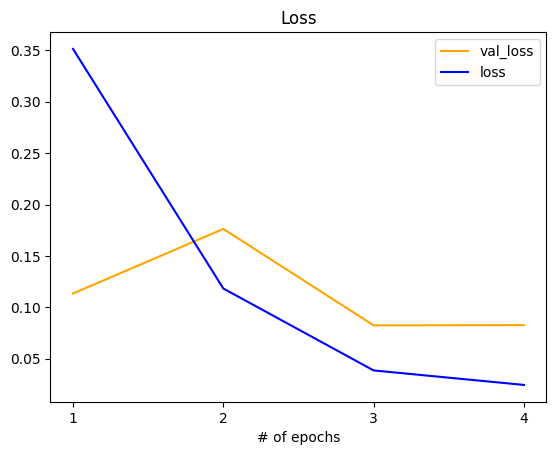

optimal number of epochs found = 3 with training Loss = tensor(0.0386) and validation Loss = tensor(0.0824)


In [ ]:
# Validating phase - tuning hyperparameters

batch_size = 16 # for training
epochs = 4 # num of epochs to train
warm_up = 0.02 # warm_up as percentage of total training steps
max_seq_length = 128 # max sequence length of BERT model

dataloader_train, dataloader_valid = train_test_encoding(x_train,x_valid,y_train,y_valid,batch_size,max_seq_length)
w0,w1 = compute_class_weights(y_train)
weights = torch.tensor([w0, w1]).to(device)

# applying weight decay to all trainable parameters except bias and normalization layer weigths
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=4e-5)

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps = epochs*len(dataloader_train)*warm_up, num_training_steps = epochs*len(dataloader_train))


# metrics per epoch

Loss_train = []


f1_valid = []
accuracy_valid = []
Loss_valid = []


for epoch in range(epochs):

  model.train() # set model to training mode
  train_loss = 0 # accumulate loss for every batch per epoch

  # training loop
  for step,batch in enumerate(tqdm(dataloader_train)):

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)
    model.zero_grad() # clear gradients
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    # weighted loss for class imbalance
    criterion = torch.nn.CrossEntropyLoss(weight=weights,reduction='mean')
    batch_loss = criterion(outputs.logits, labels)
    # batch_loss = outputs.loss # loss for the batch if we dont have weighted loss function
    train_loss += batch_loss
    batch_loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # Update the learning rate.
    scheduler.step()





  Loss_train.append(train_loss/len(dataloader_train))# compute the average loss for all the batches in epoch

  model.eval() # set model to evaluation mode
  valid_loss = 0 # accumulate loss for every batch
  all_logits = [] # store logits of every batch to pass them all into function get predictions and take the predictions overall

  # evaluation
  for step,batch in enumerate(dataloader_valid):

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to (device)

    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    batch_loss = outputs.loss # loss for the batch
    all_logits.append(outputs.logits.cpu())
    valid_loss += batch_loss

  all_logits = torch.cat(all_logits, dim=0)
  pred = get_predictions(all_logits)
  valid_loss = (valid_loss/len(dataloader_valid)) # compute the average loss for all the batches in epoch

   # validation metrics
  Loss_valid.append(valid_loss)
  accuracy_valid.append(accuracy_score(y_valid,pred))
  f1_valid.append(f1_score(y_valid, pred, average='macro'))



# learning curves

epoch = [c for c in range(1,epochs+1)]

validation_loss = [loss.cpu() for loss in Loss_valid]
training_loss = [tensor.detach().cpu() for tensor in Loss_train]

# plot learning curve
plt.figure()
plt.title('Loss')
plt.plot(epoch,validation_loss,color='orange',label='validation')
plt.plot(epoch,training_loss,color='blue',label='train')
plt.xlabel('# of epochs')
plt.xticks(epoch)
plt.legend(['val_loss', 'loss'])
plt.show()


optimal_epochs = np.argmin(validation_loss) + 1
print("optimal number of epochs found = " +str(optimal_epochs)+" with training Loss = "+str(training_loss[optimal_epochs-1])+" and validation Loss = "+str(validation_loss[optimal_epochs-1]))

In [ ]:
# # RUN THIS FOR TRAINING THE PRETRAINING MODEL after fine tuning

# # train from the initial pretrained phase of model with train data
# # finally evaluate on test set and in custom test set

# dataloader_train, dataloader_test = train_test_encoding(x_train,Xtest,y_train,ytest,batch_size,max_seq_length)
# w0,w1 = compute_class_weights(y_train)
# weights = torch.tensor([w0, w1]).to(device)

# # set the optimizer
# no_decay = ['bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.1},
#     {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]
# optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)

# # new scheduler to train the model in all avaliable training data
# scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=fine_tune_epochs*len(dataloader_train)*warm_up, num_training_steps = fine_tune_epochs*len(dataloader_train))

In [ ]:
# model.train() # set model to training mode


# for epoch in range(fine_tune_epochs):

#   # training loop
#   for step,batch in enumerate(tqdm(dataloader_train)):

#     input_ids = batch[0].to(device)
#     attention_mask = batch[1].to(device)
#     labels = batch[2].to(device)
#     model.zero_grad() # clear gradients
#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels) # forward pass
#     # weighted loss for class imbalance
#     criterion = torch.nn.CrossEntropyLoss(weight=weights,reduction='mean')
#     batch_loss = criterion(outputs.logits, labels)
#     # batch_loss = outputs.loss # loss for the batch if we dont have weighted loss function
#     batch_loss.backward() # compute gradients of cost function (Cross Entropy Loss) wih respect to all parameters
#     # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#     # update parameters
#     optimizer.step()
#     # Update the learning rate.
#     scheduler.step()



# model.eval() # set model to evaluation mode
# test_loss = 0 # accumulate loss for every batch
# all_logits = [] # store logits of every batch to pass them all into function get predictions and take the predictions overall

# # evaluation of Xtest
# for step,batch in enumerate(dataloader_test):

#   input_ids = batch[0].to(device)
#   attention_mask = batch[1].to(device)
#   labels = batch[2].to(device)

#   with torch.no_grad():
#     outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#   batch_loss = outputs.loss # loss for the batch
#   all_logits.append(outputs.logits.cpu())
#   test_loss += batch_loss


# all_logits = torch.cat(all_logits, dim=0)
# pred = get_predictions(all_logits)
# test_loss = test_loss/len(dataloader_test) # compute the average loss for all the batches
# print("results on: "+str(sets[0]))
# print("Loss is "+str(test_loss))
# print("Classification report:\n\n"+str(classification_report(ytest,pred,target_names=['ham','spam'])))
# print("accuracy is "+str(round(accuracy_score(ytest,pred),4)))
# print("balanced accuracy is "+str(round(balanced_accuracy_score(ytest,pred),4)))
# print("f1 macro is "+str(round(f1_score(ytest,pred,average='macro'),4)))
# print("confusion matrix"+str(confusion_matrix(ytest, pred))+"\n") # [[TN FP],[FN TP]]




# # evaluation of test dataset except Xtest
# predictions = []
# for i in range(1,len(X_testing)):

#   #encoding
#   encoded_test = tokenizer.batch_encode_plus(X_testing[i].tolist(), add_special_tokens=True, max_length = max_seq_length, padding='max_length' , truncation=True, return_tensors = 'pt')
#   input_ids_test = encoded_test['input_ids']
#   attention_mask_test = encoded_test['attention_mask']
#   labels_test = torch.tensor(y_testing[i])

#   data_test = TensorDataset(input_ids_test, attention_mask_test, labels_test)
#   dataloader_test = DataLoader(
#               data_test, # The validation samples.
#               batch_size = batch_size, # Evaluate with this batch size.
#               shuffle = False
#           )

#   test_loss = 0 # accumulate loss for every batch
#   all_logits = [] # store logits of every batch to pass them all into function get predictions and take the predictions overall

#   # evaluation
#   for step,batch in enumerate(dataloader_test):

#     input_ids = batch[0].to(device)
#     attention_mask = batch[1].to(device)
#     labels = batch[2].to(device)

#     with torch.no_grad():
#       outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#     batch_loss = outputs.loss # loss for the batch
#     all_logits.append(outputs.logits.cpu())
#     test_loss += batch_loss


#   all_logits = torch.cat(all_logits, dim=0)
#   pred = get_predictions(all_logits)
#   predictions.append(pred)
#   test_loss = test_loss/len(dataloader_test) # compute the average loss for all the batches
#   print("results on: "+str(sets[i]))
#   print("Loss is "+str(test_loss))
#   print("Classification report:\n\n"+str(classification_report(y_testing[i],pred,target_names=['ham','spam'])))
#   print("accuracy is "+str(round(accuracy_score(y_testing[i],pred),4)))
#   print("balanced accuracy is "+str(round(balanced_accuracy_score(y_testing[i],pred),4)))
#   print("f1 macro is "+str(round(f1_score(y_testing[i],pred,average='macro'),4)))
#   print("confusion matrix"+str(confusion_matrix(y_testing[i], pred))+"\n") # [[TN FP],[FN TP]]


In [ ]:
# # save the fine tuned model
# torch.save(model.state_dict(),'/content/drive/My Drive/spam_detection/thematic_filtering/Greek_BERT_advertisement_filter.pth')